In [3]:
import gym

import numpy as np
import pandas as pd
import pathlib

from IPython.core.pylabtools import figsize
from tqdm.notebook import tqdm
import itertools

from lcs import Perception


import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Import common utils code
%run utils/experiments.py
%run utils/bayes.py

In [4]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/cache/'

## Compute populations
All algorithms will be run one more time to create a final list of population

In [11]:
%%time

# LCS helpers
def grid_knowledge(population, env):
    return 0


def grid_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': grid_knowledge(population, env),
        'generalization': generalization_score(population)
    }



def run_grid(trials_explore, trials_exploit):
    # noinspection PyUnresolvedReferences
    import gym_grid

    grid = gym.make('grid-20-v0')

    grid_transitions = grid.env._transitions

    unique_states = set()
    for (s0, a, s1) in grid_transitions:
        unique_states.add(s0)
        unique_states.add(s1)

    grid_state_mapping = {idx: s for idx, s in enumerate(unique_states)}

    # DynaQ helpers
    def grid_perception_to_int(p0):
        p0m = tuple(map(int, p0))
        return list(grid_state_mapping.keys())[list(grid_state_mapping.values()).index(p0m)]

    def dynaq_grid_knowledge_calculator(model, env):
        # dummy
        return 0


    common_params = {
        'env': grid,
        'observation_wrapper': None,
        'classifier_length': 2,
        'possible_actions': 4,
        'learning_rate': 0.1,
        'metrics_trial_freq': 1,
        'metrics_fcn': grid_metrics_collector,
        'trials': trials_explore
    }

    acs_params = {}
    acs2_params = {'do_ga': False, 'initial_q': 0.5}
    acs2_oiq_params = {'do_ga': False, 'initial_q': 0.8}
    acs2_ga_params = {'do_ga': True, 'initial_q': 0.5}
    acs2_ga_oiq_params = {'do_ga': True, 'initial_q': 0.8}

    yacs_params = {
        'trace_length': 3,
        'estimate_expected_improvements': False,
        'feature_possible_values': [
            set(str(i) for i in range(20)),
            set(str(i) for i in range(20))
        ]
    }

    dynaq_params = {
        'q_init': np.zeros((len(grid_state_mapping), 4)),
        'model_init': {},
        'perception_to_state_mapper': grid_perception_to_int,
        'knowledge_fcn': dynaq_grid_knowledge_calculator,
        'epsilon': 0.5
    }

    # explore phase
    explore_result = run_experiment_parallel(common_params,
                                             acs_params=acs_params,
                                             acs2_params=acs2_params,
                                             acs2_oiq_params=acs2_oiq_params,
                                             acs2_ga_params=acs2_ga_params,
                                             acs2_ga_oiq_params=acs2_ga_oiq_params,
                                             yacs_params=yacs_params,
                                             dynaq_params=dynaq_params)

    # exploit phase
    common_params['trials'] = trials_exploit
    acs_params['init_population'] = explore_result[0]['acs'].get_population()

    acs2_params['init_population'] = explore_result[0]['acs2'].get_population()
    acs2_oiq_params['init_population'] = explore_result[0]['acs2_oiq'].get_population()
    acs2_ga_params['init_population'] = explore_result[0]['acs2_ga'].get_population()
    acs2_ga_oiq_params['init_population'] = explore_result[0]['acs2_ga_oiq'].get_population()

    yacs_params['init_population'] = explore_result[0]['yacs'].get_population()
    yacs_params['init_desirability_values'] = explore_result[0]['yacs'].desirability_values

    dynaq_params['q_init'] = explore_result[0]['dynaq'][0]
    dynaq_params['model_init'] = explore_result[0]['dynaq'][1]
    dynaq_params['epsilon'] = 1.0

    exploit_result = run_experiment_parallel(common_params,
                                             acs_params=acs_params,
                                             acs2_params=acs2_params,
                                             acs2_oiq_params=acs2_oiq_params,
                                             acs2_ga_params=acs2_ga_params,
                                             acs2_ga_oiq_params=acs2_ga_oiq_params,
                                             yacs_params=yacs_params,
                                             dynaq_params=dynaq_params)

    return explore_result, exploit_result

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 27.7 µs


In [14]:
df = pd.DataFrame(columns=['agent', 'trial_steps'])

for i in tqdm(range(0, 5), desc='Run'):
    _, exploit_output = run_grid(250, 50)
    metrics_df = exploit_output[1].reset_index()
    df = pd.concat([df, metrics_df[['agent', 'trial_steps']]])

Run: 100%|██████████| 5/5 [4:27:23<00:00, 3208.72s/it]  


# Bayesian estimation of performance

The null hypothesis is that the performance of two classifiers is practically the same. To either accept or reject it the  ROPE and HDI intervals will be used.

## Go with all combinations

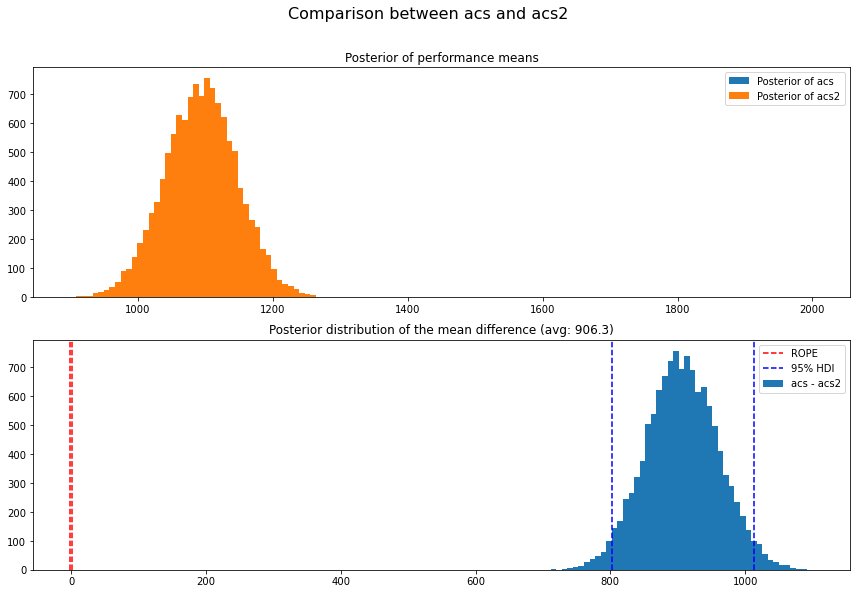

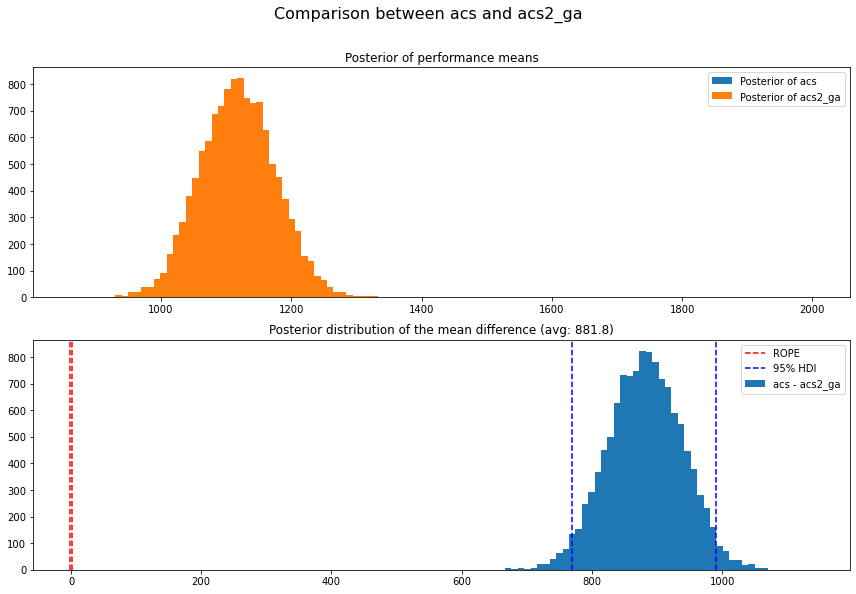

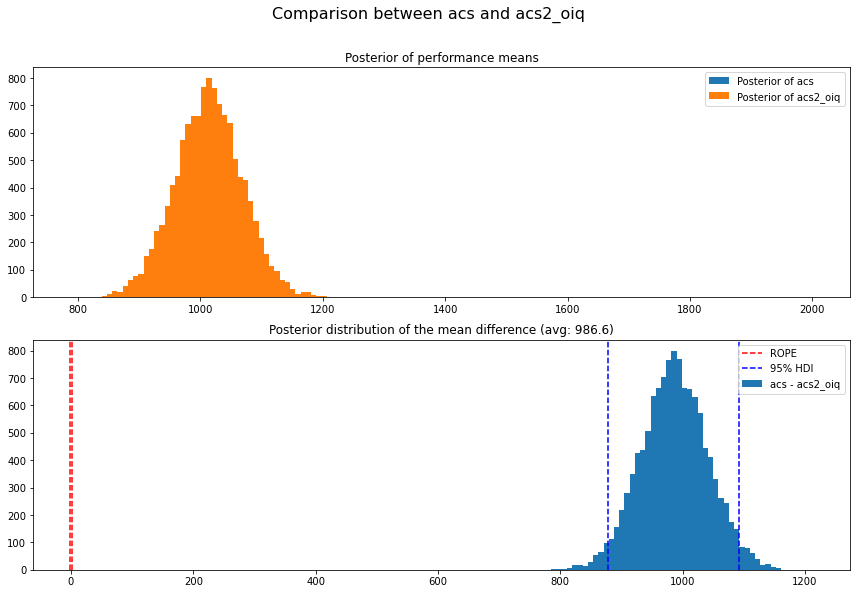

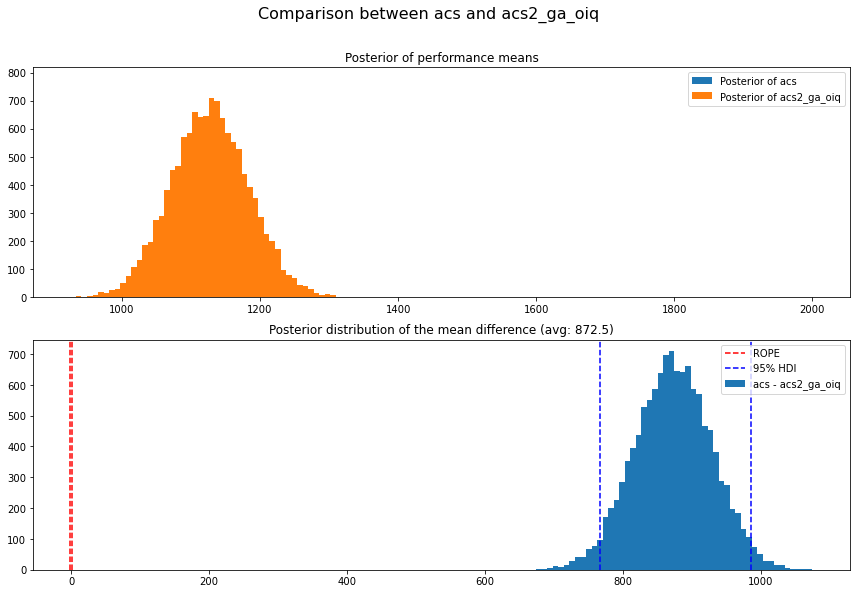

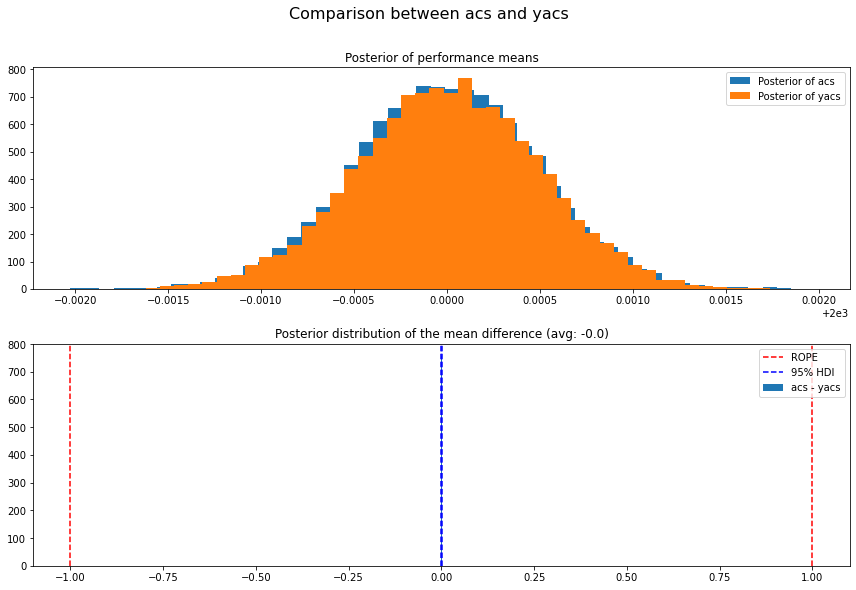

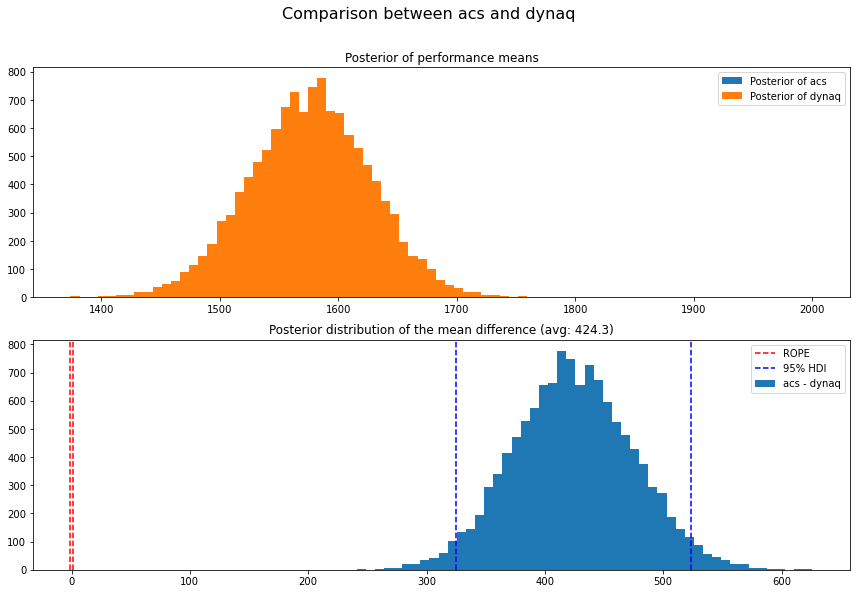

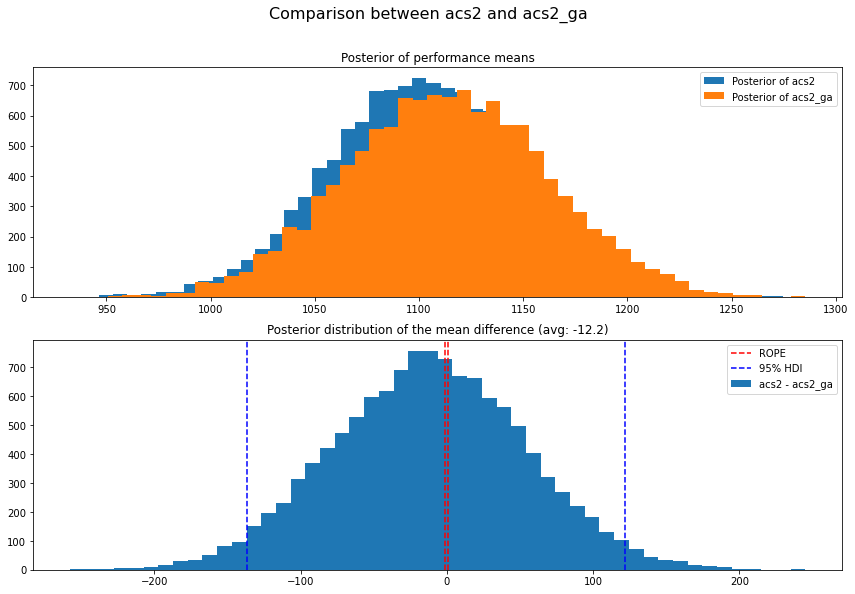

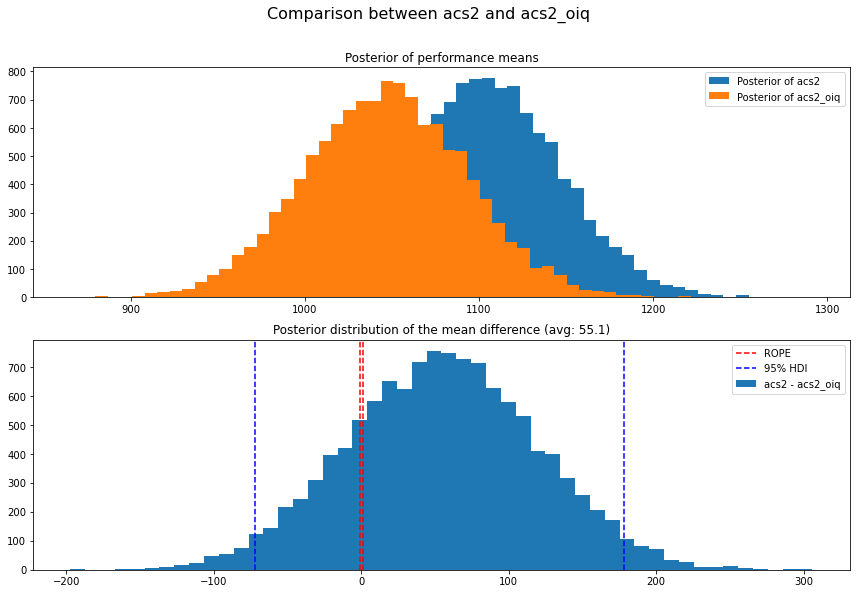

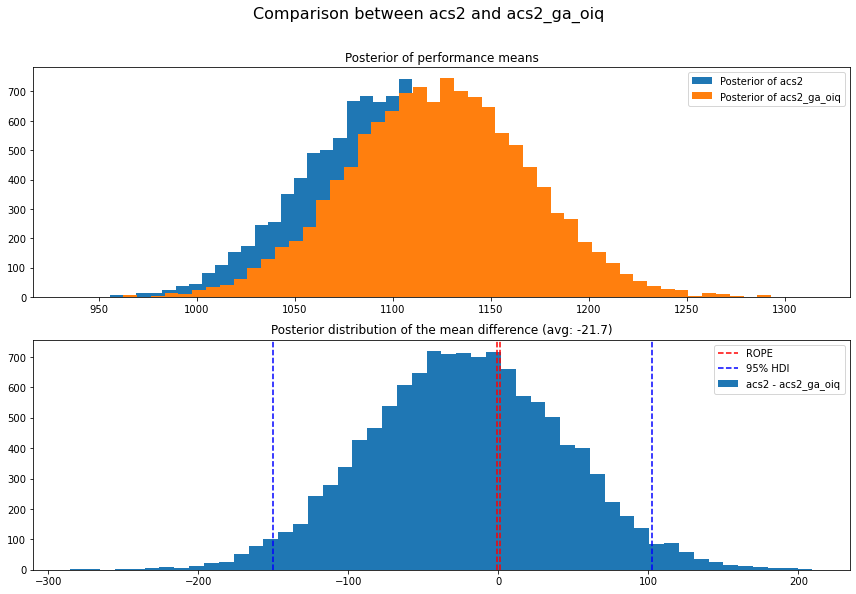

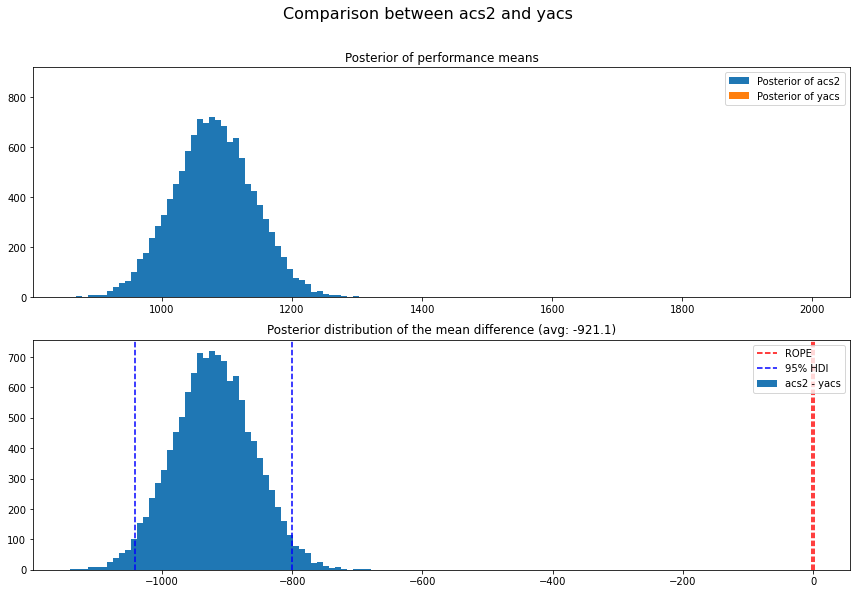

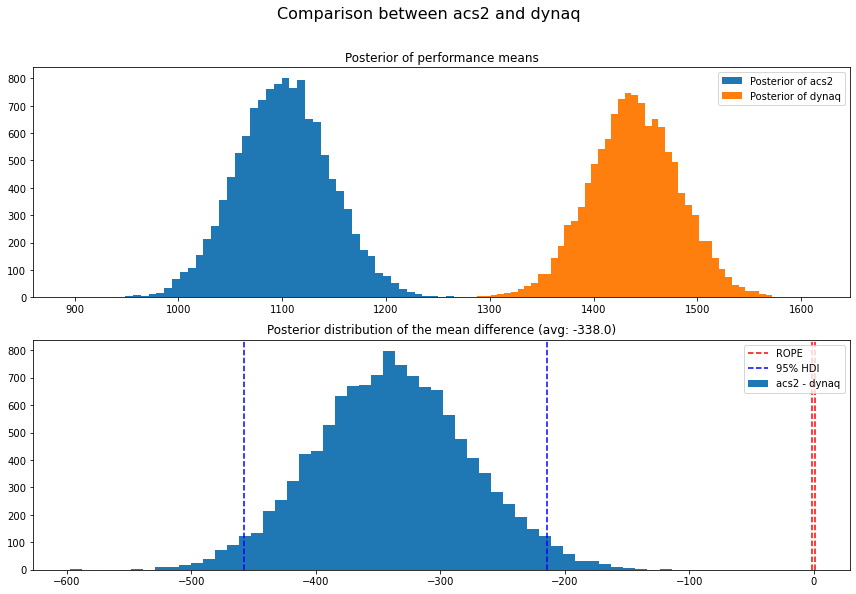

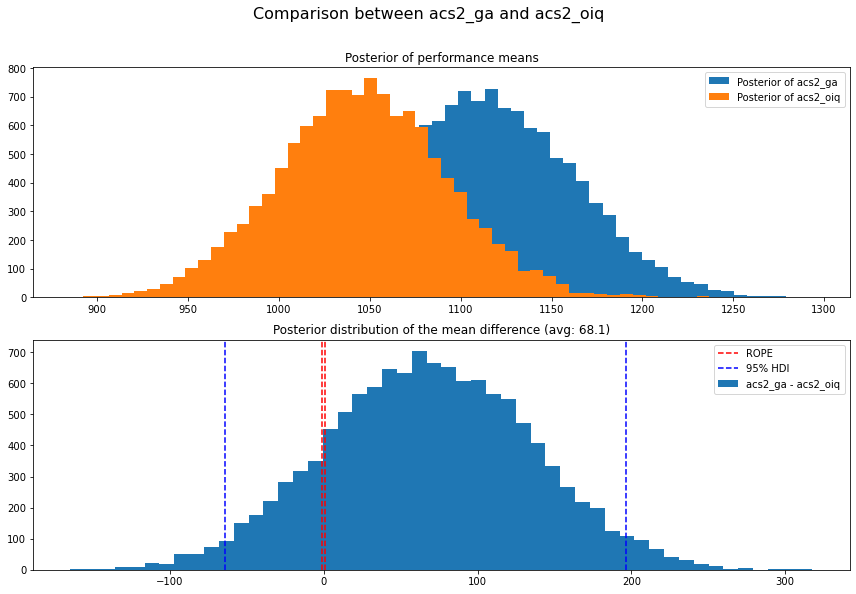

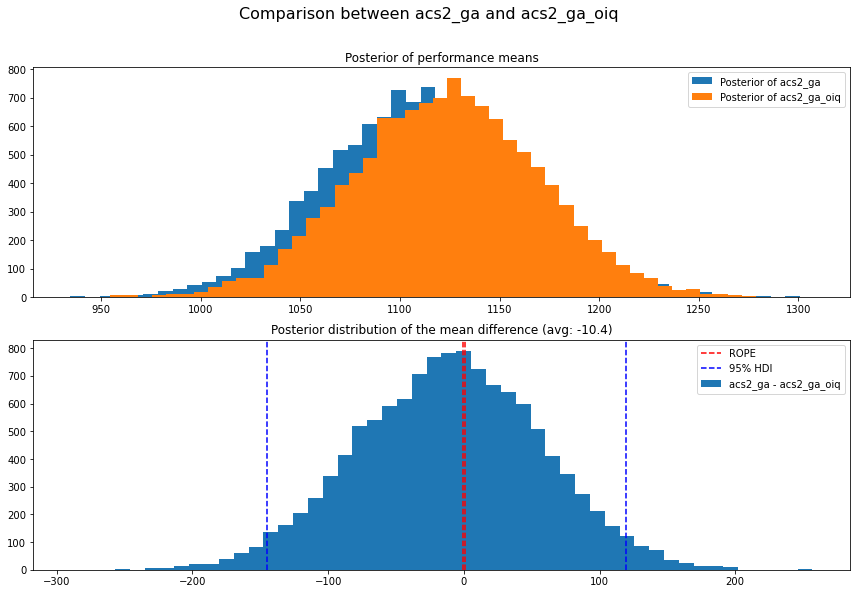

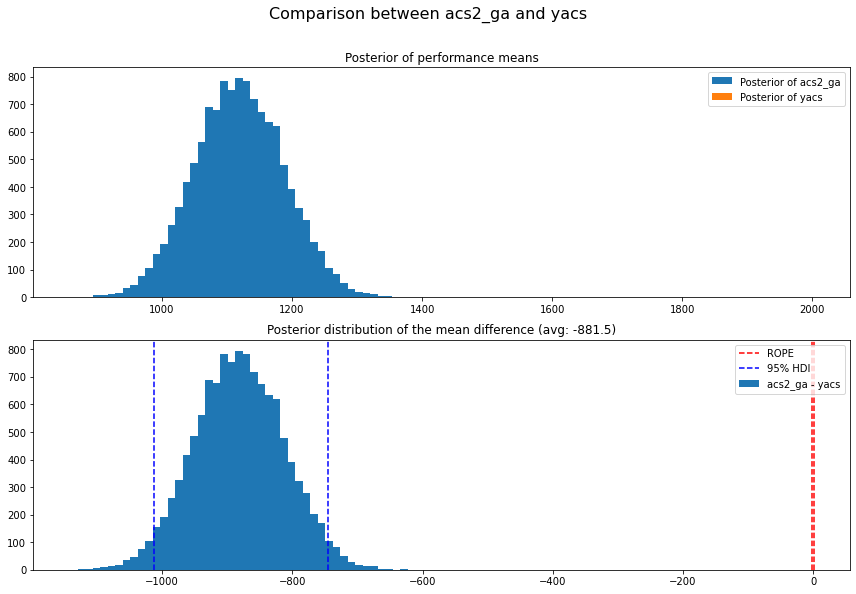

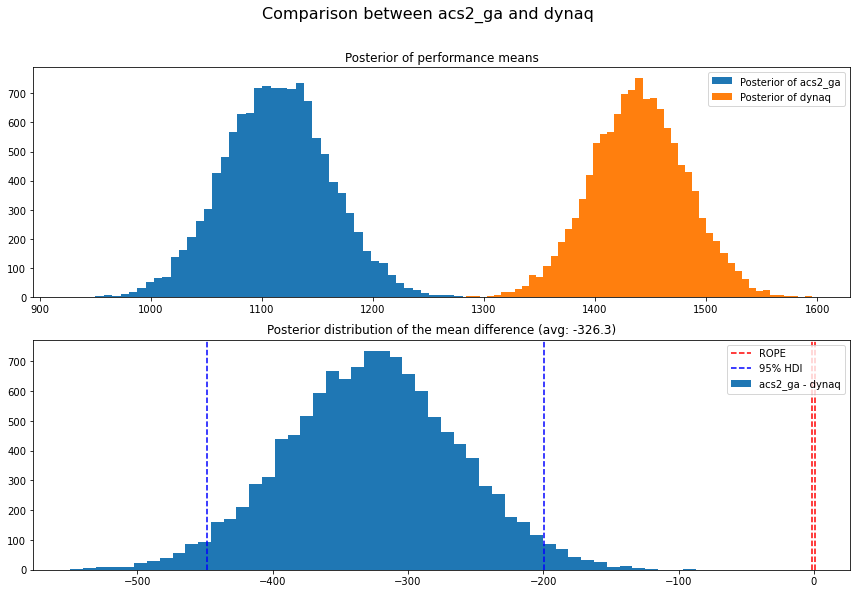

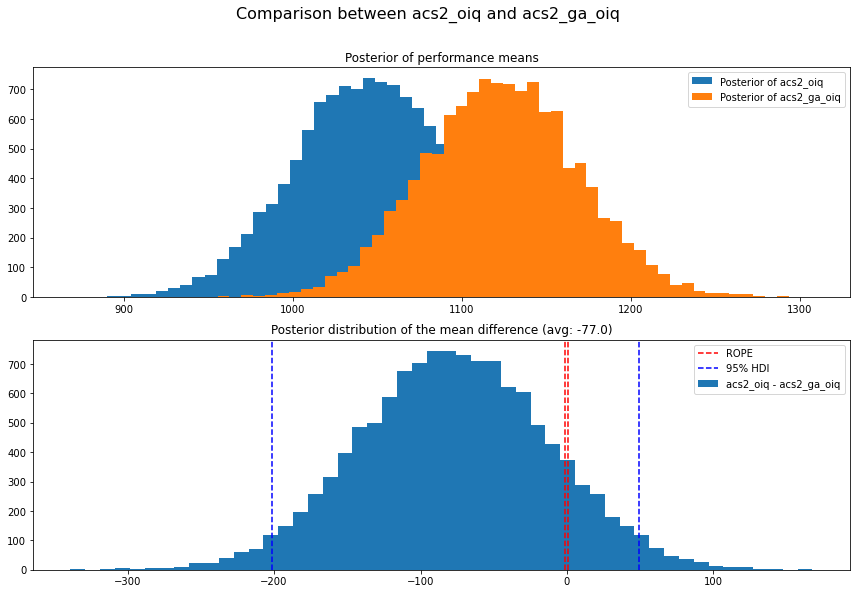

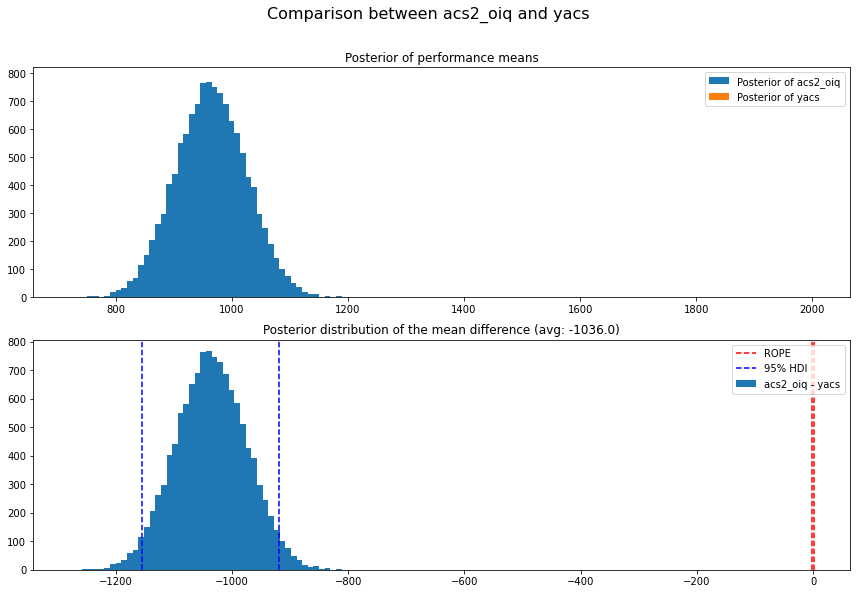

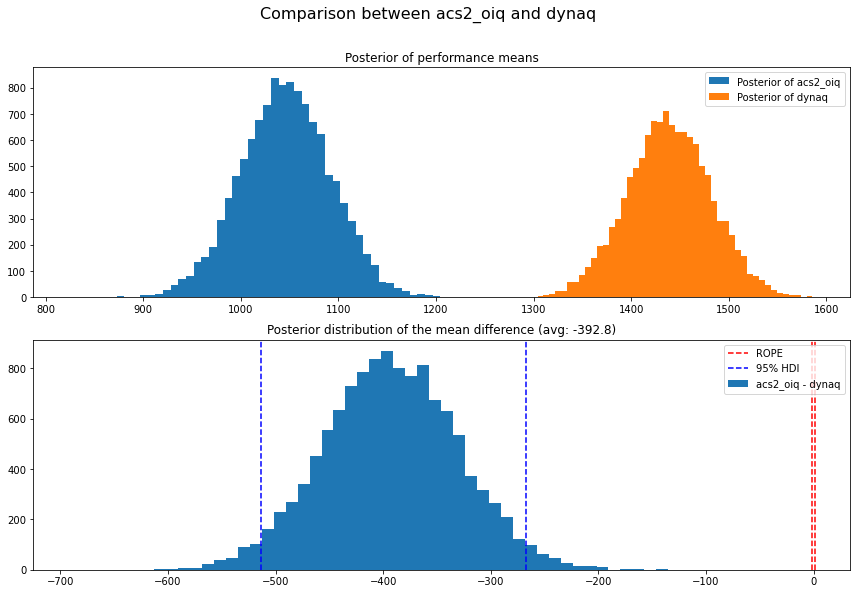

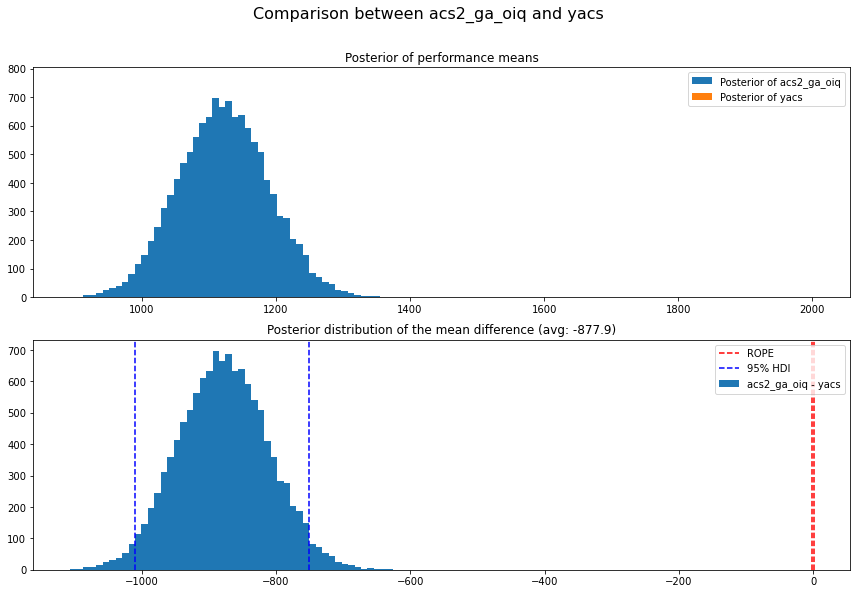

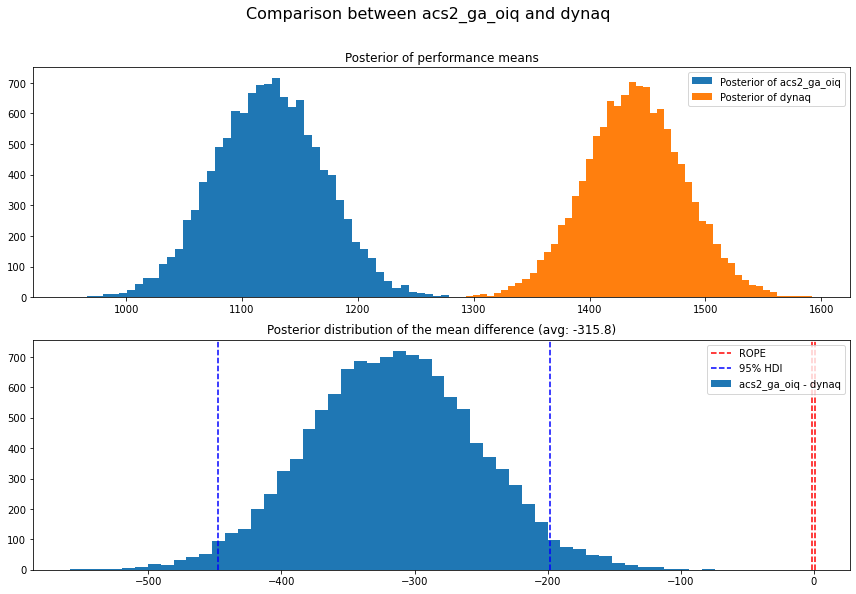

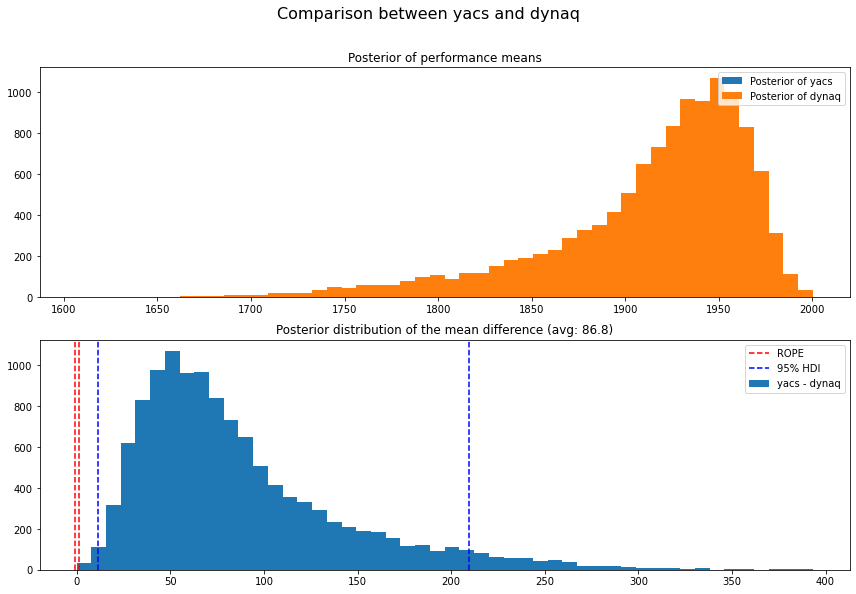

In [16]:
figsize(12, 12)
algs = ['acs', 'acs2', 'acs2_ga', 'acs2_oiq', 'acs2_ga_oiq', 'yacs', 'dynaq']

summary = []

for cl1, cl2 in itertools.combinations(algs, 2):
    trace = compare_two_classifiers(df, cl1, cl2)
    rope, hdi = visualize(trace, cl1, cl2)
    summary.append({
        'model1': cl1,
        'model2': cl2,
        'model1_avg_steps': trace['mu_1'].mean(),
        'model2_avg_steps': trace['mu_2'].mean(),
        'diff': trace['mu_1'].mean() - trace['mu_2'].mean(),
        'hdi_95': hdi,
        'h0': inference(rope, hdi)
    })